In [1]:
import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns',None)

import seaborn as sns
sns.set(font_scale=1.2)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
%matplotlib inline

In [27]:
# constant

import os
from datetime import datetime

ROOT_DIR = os.getcwd()  #to get current working directory

MODELS_DIR = "Models"
IMAGES_DIR = "Images"
DOCS_DIR = "Docs"
MODELS_FILE_PATH = os.path.join(ROOT_DIR, MODELS_DIR)
IMAGES_FILE_PATH = os.path.join(ROOT_DIR, IMAGES_DIR)
DOCS_FILE_PATH = os.path.join(ROOT_DIR, DOCS_DIR)

CURRENT_TIME_STAMP = f"{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

LOG_DIR = "Model_Logs"
LOG_FILE_NAME = f"Log_{CURRENT_TIME_STAMP}.log"
LOG_FILE_PATH = os.path.join(ROOT_DIR, LOG_DIR, LOG_FILE_NAME)

DATASET_FILE_PATH = "part6\\Historical Weather Data 2010-2021_preprocessed_1.csv"

ARTIFACT_DIR = "Artifact"
DATA_INGESTION_DIR = "Ingested_data"
TRAIN_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"
DATA_INGESTION_PATH = os.path.join(ROOT_DIR, ARTIFACT_DIR, CURRENT_TIME_STAMP, DATA_INGESTION_DIR)
TRAIN_FILE_PATH = os.path.join(DATA_INGESTION_PATH, TRAIN_FILE_NAME)
TEST_FILE_PATH = os.path.join(DATA_INGESTION_PATH, TEST_FILE_NAME)

MULTILABEL_MODEL_RESULT_DIR = "MultiLabel_Model_Result"
MULTILABEL_MODEL_RESULT_FILE_NAME = "MultiLabel_Model_Result.csv"
MULTILABEL_MODEL_RESULT_PATH = os.path.join(ROOT_DIR, ARTIFACT_DIR, CURRENT_TIME_STAMP, MULTILABEL_MODEL_RESULT_DIR)
MULTILABEL_MODEL_RESULT_FILE_PATH = os.path.join(MULTILABEL_MODEL_RESULT_DIR, MULTILABEL_MODEL_RESULT_FILE_NAME)



In [28]:
# logger

import logging
from datetime import datetime
import os

os.makedirs(LOG_DIR, exist_ok=True)

logging.basicConfig(
    filename=LOG_FILE_PATH,
    filemode="w",
    format='[%(asctime)s] %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)

In [29]:
# exception

import os
import sys


class ModelException(Exception):

    def __init__(self, error_message : Exception, error_detail : sys) -> None:
        super().__init__(error_message)
        self.error_message = ModelException.get_detailed_error_message(
            error_message = error_message, 
            error_detail = error_detail
            ) # error_message

    @staticmethod
    def get_detailed_error_message(error_message : Exception, error_detail : sys) -> str:
        '''
        Description : This function is going to return error string. 

        error_message: Exception object
        error_detail: object of sys module

        return error string
        '''
        # _, _, exec_tb = error_detail.exc_info()
        # line_number = exec_tb.tb_lineno # exec_tb.tb_frame.f_lineno
        # file_name = exec_tb.tb_frame.f_code.co_filename
        # error_message = f"""
        # Error occured in scrip : [{file_name}] at 
        # line number : [{line_number}] 
        # error message: [{error_message}]"""

        _, _, exec_tb = error_detail.exc_info()
        exception_block_line_number = exec_tb.tb_frame.f_lineno
        try_block_line_number = exec_tb.tb_lineno
        file_name = exec_tb.tb_frame.f_code.co_filename
        error_message = f"""
        Error occured in script : [ {file_name} ] at 
        try block line number : [ {try_block_line_number} ] and 
        exception block line number : [ {exception_block_line_number} ] 
        error message : [ {error_message} ]
        """
        
        return error_message

    def __str__(self):
        return self.error_message

    def __repr__(self) -> str:
        return ModelException.__name__.str()

In [30]:
# util

def multilabel_encoder(binary) -> int:
    '''
    Read the multilabel value and return its label in int.
    '''
    
    try: 
        binary1 = binary
        decimal, i, n = 0, 0, 0
        while(binary != 0):
            dec = binary % 10
            decimal = decimal + dec * pow(2, i)
            binary = binary//10
            i += 1
        return int(decimal)   
    except Exception as e:
        raise ModelException(e, sys) from e

multilabel_encoder(1001)     

9

In [31]:
# load dataset

df = pd.read_csv(DATASET_FILE_PATH)
df.head(3)

,observation,date,month,year,tempC_7to8,tempC_1to2,tempC_6to7,tempC_avg(0C),Relative humidity_7to8,Relative humidity_1to2,Relative humidity_6to7,Relative humidity_avg(%),windspeedKmph_7to8,windspeedKmph_1to2,windspeedKmph_6to7,windspeedKmph_avg(Km/h),pressureMB_7to8,pressureMB_1to2,pressureMB_6to7,pressureMB_avg,precipMM_7to8,precipMM_1to2,precipMM_6to7,precipMM_avg(mm),weatherDesc_7to8,weatherDesc_1to2,weatherDesc_6to7,weatherDesc,Sunshine Hours,%_soil_moisure,soil_pH,water_pH,water_TDS_mgpl,Label (Disease Yes/No),Type of Disease (Bacterial Blight/Telya),Anthracnose,Fruit Spot/ Rot,Fusarium Wilt,Fruit Borer / Blight Blora
0,2010-01-01,1,1,2010,20,30,20,23,42,33,59,44,9,2,4,5,1015,1012,1013,1013,0.0,0.0,0.0,0.0,5,5,5,5,9.8,45,6.91,7.18,1709.0,0,0,0,0,0,0
1,2010-01-02,2,1,2010,23,29,23,25,49,40,62,50,9,3,3,5,1015,1013,1015,1014,0.0,0.0,0.0,0.0,5,4,4,4,9.8,45,6.77,7.66,1707.0,1,1,1,0,0,0
2,2010-01-03,3,1,2010,24,27,21,24,61,50,78,63,4,8,6,6,1017,1014,1015,1015,0.0,0.0,0.0,0.0,4,4,4,4,9.8,41,6.76,7.44,1707.0,0,0,0,0,0,0


In [32]:
# columns name 

print(list(df.columns))

['observation', 'date', 'month', 'year', 'tempC_7to8', 'tempC_1to2', 'tempC_6to7', 'tempC_avg(0C)', 'Relative humidity_7to8', 'Relative humidity_1to2', 'Relative humidity_6to7', 'Relative humidity_avg(%)', 'windspeedKmph_7to8', 'windspeedKmph_1to2', 'windspeedKmph_6to7', 'windspeedKmph_avg(Km/h)', 'pressureMB_7to8', 'pressureMB_1to2', 'pressureMB_6to7', 'pressureMB_avg', 'precipMM_7to8', 'precipMM_1to2', 'precipMM_6to7', 'precipMM_avg(mm)', 'weatherDesc_7to8', 'weatherDesc_1to2', 'weatherDesc_6to7', 'weatherDesc', 'Sunshine Hours', '%_soil_moisure', 'soil_pH', 'water_pH', 'water_TDS_mgpl', 'Label (Disease Yes/No)', 'Type of Disease (Bacterial Blight/Telya)', 'Anthracnose', 'Fruit Spot/ Rot', 'Fusarium Wilt', 'Fruit Borer / Blight Blora']


In [33]:
# dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   observation                               4227 non-null   object 
 1   date                                      4227 non-null   int64  
 2   month                                     4227 non-null   int64  
 3   year                                      4227 non-null   int64  
 4   tempC_7to8                                4227 non-null   int64  
 5   tempC_1to2                                4227 non-null   int64  
 6   tempC_6to7                                4227 non-null   int64  
 7   tempC_avg(0C)                             4227 non-null   int64  
 8   Relative humidity_7to8                    4227 non-null   int64  
 9   Relative humidity_1to2                    4227 non-null   int64  
 10  Relative humidity_6to7              

In [34]:
# %%timeit
df['NewLabel'] = df.apply(lambda x: multilabel_encoder(
    int(str(x['Type of Disease (Bacterial Blight/Telya)']) + 
        str(x['Anthracnose']) + 
        str(x['Fruit Spot/ Rot']) + 
        str(x['Fusarium Wilt']) + 
        str(x['Fruit Borer / Blight Blora']))),axis=1)
df.head()

,observation,date,month,year,tempC_7to8,tempC_1to2,tempC_6to7,tempC_avg(0C),Relative humidity_7to8,Relative humidity_1to2,Relative humidity_6to7,Relative humidity_avg(%),windspeedKmph_7to8,windspeedKmph_1to2,windspeedKmph_6to7,windspeedKmph_avg(Km/h),pressureMB_7to8,pressureMB_1to2,pressureMB_6to7,pressureMB_avg,precipMM_7to8,precipMM_1to2,precipMM_6to7,precipMM_avg(mm),weatherDesc_7to8,weatherDesc_1to2,weatherDesc_6to7,weatherDesc,Sunshine Hours,%_soil_moisure,soil_pH,water_pH,water_TDS_mgpl,Label (Disease Yes/No),Type of Disease (Bacterial Blight/Telya),Anthracnose,Fruit Spot/ Rot,Fusarium Wilt,Fruit Borer / Blight Blora,NewLabel
0,2010-01-01,1,1,2010,20,30,20,23,42,33,59,44,9,2,4,5,1015,1012,1013,1013,0.0,0.0,0.0,0.0,5,5,5,5,9.8,45,6.91,7.18,1709.0,0,0,0,0,0,0,0
1,2010-01-02,2,1,2010,23,29,23,25,49,40,62,50,9,3,3,5,1015,1013,1015,1014,0.0,0.0,0.0,0.0,5,4,4,4,9.8,45,6.77,7.66,1707.0,1,1,1,0,0,0,24
2,2010-01-03,3,1,2010,24,27,21,24,61,50,78,63,4,8,6,6,1017,1014,1015,1015,0.0,0.0,0.0,0.0,4,4,4,4,9.8,41,6.76,7.44,1707.0,0,0,0,0,0,0,0
3,2010-01-04,4,1,2010,23,29,20,24,57,30,52,46,5,7,6,6,1016,1012,1013,1013,0.0,0.0,0.0,0.0,5,5,5,5,9.8,43,7.10,7.43,1708.0,0,0,0,0,0,0,0
4,2010-01-05,5,1,2010,22,30,21,24,48,34,54,45,6,2,4,4,1013,1010,1012,1011,0.0,0.0,0.0,0.0,5,5,5,5,9.8,44,6.53,8.05,1709.0,0,0,0,0,0,0,0


In [35]:
df.shape

(4227, 40)

In [37]:
print('unique values : ', df['NewLabel'].unique()) 
print('unique value count : ', len(df['NewLabel'].unique())) 
print('value_counts : \n', df['NewLabel'].value_counts())

unique values :  [ 0 24 16 22 21 26  6  5  1 25 17  8  2  9  7 27 23 29]
unique value count :  18
value_counts : 
 0     2405
24     612
16     327
1      292
5      282
21      96
17      60
6       59
25      45
22      18
26      13
7        7
2        4
9        2
8        2
29       1
23       1
27       1
Name: NewLabel, dtype: int64


<AxesSubplot:>

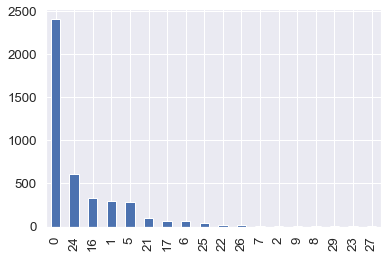

In [38]:
df['NewLabel'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='NewLabel'>

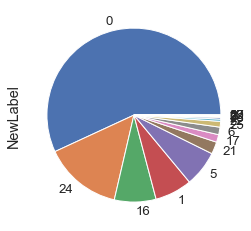

In [39]:
df['NewLabel'].value_counts().plot(kind='pie')

In [40]:
df['NewLabel'].value_counts().index, df['NewLabel'].value_counts().values 

(Int64Index([0, 24, 16, 1, 5, 21, 17, 6, 25, 22, 26, 7, 2, 9, 8, 29, 23, 27], dtype='int64'),
 array([2405,  612,  327,  292,  282,   96,   60,   59,   45,   18,   13,
           7,    4,    2,    2,    1,    1,    1], dtype=int64))

In [41]:
list_val = [k for k,v in zip(df['NewLabel'].value_counts().index, df['NewLabel'].value_counts().values) if v < 20]
list_val

[22, 26, 7, 2, 9, 8, 29, 23, 27]

In [42]:
for k in list_val:
    df.drop(df[df['NewLabel'] == k].index, inplace = True)

In [43]:
df.head()

,observation,date,month,year,tempC_7to8,tempC_1to2,tempC_6to7,tempC_avg(0C),Relative humidity_7to8,Relative humidity_1to2,Relative humidity_6to7,Relative humidity_avg(%),windspeedKmph_7to8,windspeedKmph_1to2,windspeedKmph_6to7,windspeedKmph_avg(Km/h),pressureMB_7to8,pressureMB_1to2,pressureMB_6to7,pressureMB_avg,precipMM_7to8,precipMM_1to2,precipMM_6to7,precipMM_avg(mm),weatherDesc_7to8,weatherDesc_1to2,weatherDesc_6to7,weatherDesc,Sunshine Hours,%_soil_moisure,soil_pH,water_pH,water_TDS_mgpl,Label (Disease Yes/No),Type of Disease (Bacterial Blight/Telya),Anthracnose,Fruit Spot/ Rot,Fusarium Wilt,Fruit Borer / Blight Blora,NewLabel
0,2010-01-01,1,1,2010,20,30,20,23,42,33,59,44,9,2,4,5,1015,1012,1013,1013,0.0,0.0,0.0,0.0,5,5,5,5,9.8,45,6.91,7.18,1709.0,0,0,0,0,0,0,0
1,2010-01-02,2,1,2010,23,29,23,25,49,40,62,50,9,3,3,5,1015,1013,1015,1014,0.0,0.0,0.0,0.0,5,4,4,4,9.8,45,6.77,7.66,1707.0,1,1,1,0,0,0,24
2,2010-01-03,3,1,2010,24,27,21,24,61,50,78,63,4,8,6,6,1017,1014,1015,1015,0.0,0.0,0.0,0.0,4,4,4,4,9.8,41,6.76,7.44,1707.0,0,0,0,0,0,0,0
3,2010-01-04,4,1,2010,23,29,20,24,57,30,52,46,5,7,6,6,1016,1012,1013,1013,0.0,0.0,0.0,0.0,5,5,5,5,9.8,43,7.10,7.43,1708.0,0,0,0,0,0,0,0
4,2010-01-05,5,1,2010,22,30,21,24,48,34,54,45,6,2,4,4,1013,1010,1012,1011,0.0,0.0,0.0,0.0,5,5,5,5,9.8,44,6.53,8.05,1709.0,0,0,0,0,0,0,0


In [44]:
df.shape

(4178, 40)

In [45]:
4227 - 4178

49

In [47]:
df.to_csv("part6\\Historical Weather Data 2010-2021_preprocessed_2.csv", index=False)

In [14]:
from sklearn.model_selection import train_test_split

# df1 = df[['tempC_avg(0C)', 'Relative humidity_avg(%)', 'windspeedKmph_avg(Km/h)', 
#           'pressureMB_avg', 'precipMM_avg(mm)', 'weatherDesc', 'Sunshine Hours', 
#           '%_soil_moisure', 'Type of Disease (Bacterial Blight/Telya)', 
#           'Anthracnose', 'Fruit Spot/ Rot', 'Fusarium Wilt', 
#           'Fruit Borer / Blight Blora', 'NewLabel']]

# train_data, test_data = train_test_split(df1, 
#                                          test_size = 0.3, 
#                                          random_state = 42, 
#                                          stratify = df1['NewLabel'])

In [21]:
df1 = df[['tempC_avg(0C)', 'Relative humidity_avg(%)', 'windspeedKmph_avg(Km/h)', 
          'pressureMB_avg', 'precipMM_avg(mm)', 'weatherDesc', 'Sunshine Hours', 
          '%_soil_moisure', 'Type of Disease (Bacterial Blight/Telya)', 
          'Anthracnose', 'Fruit Spot/ Rot', 'Fusarium Wilt', 
          'Fruit Borer / Blight Blora']]

train_data, test_data = train_test_split(df1, 
                                         test_size = 0.3, 
                                         random_state = 42)


'''
1st step after getting this as a parameter 
'''
os.makedirs(DATA_INGESTION_PATH, exist_ok=True)
train_data.to_csv(TRAIN_FILE_PATH, index = False)
test_data.to_csv(TEST_FILE_PATH, index = False)



In [23]:
train_df = pd.read_csv(TRAIN_FILE_PATH)

train_df.head(3)


,tempC_avg(0C),Relative humidity_avg(%),windspeedKmph_avg(Km/h),pressureMB_avg,precipMM_avg(mm),weatherDesc,Sunshine Hours,%_soil_moisure,Type of Disease (Bacterial Blight/Telya),Anthracnose,Fruit Spot/ Rot,Fusarium Wilt,Fruit Borer / Blight Blora
0,25,83,21,1001,0.166667,3,6.2,52,1,1,0,0,1
1,24,91,6,1004,0.100000,3,3.8,65,0,0,1,0,1
2,28,15,7,1010,0.000000,5,10.7,35,0,0,0,0,0


In [24]:

X = train_df[['tempC_avg(0C)', 'Relative humidity_avg(%)', 
                'windspeedKmph_avg(Km/h)', 'pressureMB_avg', 'precipMM_avg(mm)', 
                'weatherDesc', 'Sunshine Hours', '%_soil_moisure']]
Y = train_df[['Type of Disease (Bacterial Blight/Telya)', 'Anthracnose', 
                'Fruit Spot/ Rot', 'Fusarium Wilt', 'Fruit Borer / Blight Blora']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)


In [16]:
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier

lr_Classifier = LogisticRegression(max_iter=1000, random_state=3757)  
knn_Classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, p=2, weights='uniform')  
nb_Classifier = GaussianNB(priors=None, var_smoothing=1e-09)
svm_Classifier = SVC(gamma='auto')
dt_Classifier = DecisionTreeClassifier(random_state=3757)
rf_Classifier = RandomForestClassifier(n_jobs=-1, random_state=3757)
gb_Classifier = GradientBoostingClassifier(random_state=3757)
ab_Classifier = AdaBoostClassifier(random_state=3757)


'''
2nd step
'''

classifiers = [lr_Classifier, knn_Classifier, nb_Classifier, svm_Classifier, dt_Classifier, 
               rf_Classifier, gb_Classifier, ab_Classifier]

for classifier in classifiers:
    print(type(classifier).__name__, ' || ', classifier.__class__.__name__)

LogisticRegression  ||  LogisticRegression
KNeighborsClassifier  ||  KNeighborsClassifier
GaussianNB  ||  GaussianNB
SVC  ||  SVC
DecisionTreeClassifier  ||  DecisionTreeClassifier
RandomForestClassifier  ||  RandomForestClassifier
GradientBoostingClassifier  ||  GradientBoostingClassifier
AdaBoostClassifier  ||  AdaBoostClassifier


In [29]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

from sklearn.metrics import confusion_matrix

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.model_selection import cross_val_score, KFold


class POMO_MultuLabelClassifier:

    def __init__(self, classifiers : list, n_jobs : int = 2) -> None:
        '''
        '''
        self.classifiers = classifiers
        self.n_jobs = n_jobs

        # os.makedirs(LOG_DIR, exist_ok=True)
        # os.makedirs(LOG_DIR, exist_ok=True)


    def builMultiLabelModels(self, X_train, y_train, classifierModel):
        
        print('Model_name : ', type(classifierModel).__name__)

        multiLabelModel = MultiOutputClassifier(classifierModel, self.n_jobs)
        
        classifierModel = multiLabelModel.fit(X_train, y_train)
        
        y_pred = classifierModel.predict(X_test)
        
        Accuracy_score = round((accuracy_score(y_train, y_pred))*100,2)
        Loss = round((1-Accuracy_score)*100,2)
        Hamming_loss = round((hamming_loss(y_train, y_pred))*100,2)

        print("Accuracy_score:", Accuracy_score,'%')
        print("Loss:", Loss,'%')
        print("Hamming_loss:", Hamming_loss,'%')
        print("Classification_report:\n",metrics.classification_report(y_train, y_pred))
 
        return classifierModel, {'Accuracy': Accuracy_score, 
                                 'Loss': Loss, 
                                 'Hamming_loss': Hamming_loss
                                 }

    def get_MultiLabelModelResult(self, X_train, y_train) :

        result_df = pd.DataFrame()

        for classifier in self.classifiers:

            model, data = self.builMultiLabelModels(X_train, X_test, classifier)
            
            print(model, data)


        return 'Done' # result_df1
    




    def fit_model(self, X_train, y_train):
        
        # selecting top 3 models
        models_df = self.get_MultiLabelModelResult(X_train, y_train)
        
        
        
        
# https://github.com/krishnaik06/Car-PricePrediction/blob/main/Car_Price.ipynb

In [30]:
model_object = POMO_MultuLabelClassifier(classifiers)
model_object

In [31]:
model_object.fit_model(X_train, y_train)

Model_name :  LogisticRegression


c:\users\munge\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_jobs=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


ValueError: Found input variables with inconsistent numbers of samples: [2070, 888]